# Data Cleaning Challenge - Parsing dates

## Intro

### All days of the challange:

* [Day 1: Handling missing values](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)
* [Day 2: Scaling and normalization](https://www.kaggle.com/rtatman/data-cleaning-challenge-scale-and-normalize-data)
* [Day 3: Parsing dates](https://www.kaggle.com/rtatman/data-cleaning-challenge-parsing-dates/)
* [Day 4: Character encodings](https://www.kaggle.com/rtatman/data-cleaning-challenge-character-encodings/)
* [Day 5: Inconsistent Data Entry](https://www.kaggle.com/rtatman/data-cleaning-challenge-inconsistent-data-entry/)
___
Welcome to day 3 of the 5-Day Data Challenge! Today, we're going to work with dates. To get started, click the blue "Fork Notebook" button in the upper, right hand corner. This will create a private copy of this notebook that you can edit and play with. Once you're finished with the exercises, you can choose to make your notebook public to share with others. :)

> **Your turn!** As we work through this notebook, you'll see some notebook cells (a block of either code or text) that has "Your Turn!" written in it. These are exercises for you to do to help cement your understanding of the concepts we're talking about. Once you've written the code to answer a specific question, you can run the code by clicking inside the cell (box with code in it) with the code you want to run and then hit CTRL + ENTER (CMD + ENTER on a Mac). You can also click in a cell and then click on the right "play" arrow to the left of the code. If you want to run all the code in your notebook, you can use the double, "fast forward" arrows at the bottom of the notebook editor.

Here's what we're going to do today:

* [Get our environment set up](#Get-our-environment-set-up)
* [Check the data type of our date column](#Check-the-data-type-of-our-date-column)
* [Convert our date columns to datetime](#Convert-our-date-columns-to-datetime)
* [Select just the day of the month from our column](#Select-just-the-day-of-the-month-from-our-column)
* [Plot the day of the month to check the date parsing](#Plot-the-day-of-the-month-to-the-date-parsing)

Let's get started!

## Get our environment set up

The first thing we'll need to do is load in the libraries and datasets we'll be using. For today, we'll be working with two datasets: one containing information on earthquakes that occured between 1965 and 2016, and another that contains information on landslides that occured between 2007 and 2016.

> **Important!** Make sure you run this cell yourself or the rest of your code won't work!

In [2]:
# modules we'll use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Handling directories
import os
import kaggle_cleaning
from kaggle_cleaning.config import RAW_DATA_DIR, CLEAN_DATA_DIR

# read in all our data
# earthquakes
earthquakes_file = os.path.join(RAW_DATA_DIR, "database_earthquakes.csv")
earthquakes_clean_file = os.path.join(CLEAN_DATA_DIR, "earthquakes-clean.csv")
earthquakes = pd.read_csv(earthquakes_file)

# landslides
landslides_file = os.path.join(RAW_DATA_DIR, "catalog.csv")
landslides_clean_file = os.path.join(CLEAN_DATA_DIR, "landslides-clean.csv")
landslides = pd.read_csv(landslides_file)

# volcanos
volcanos_file = os.path.join(RAW_DATA_DIR, "database_volcanoes.csv")
volcanos_clean_file = os.path.join(CLEAN_DATA_DIR, "volcanoes-clean.csv")
volcanos = pd.read_csv(volcanos_file)

# read in our data
# landslides = pd.read_csv("../input/landslide-events/catalog.csv")
# volcanos = pd.read_csv("../input/volcanic-eruptions/database.csv")

# set seed for reproducibility
np.random.seed(0)

Now we're ready to look at some dates! (If you like, you can take this opportunity to take a look at some of the data.)

## Check the data type of our date column

For this part of the challenge, I'll be working with the `date` column from the `landslides` dataframe. The very first thing I'm going to do is take a peek at the first few rows to make sure it actually looks like it contains dates.

In [3]:
# print the first few rows of the date column
print(landslides['date'].head())

0     3/2/07
1    3/22/07
2     4/6/07
3    4/14/07
4    4/15/07
Name: date, dtype: object


Yep, those are dates! But just because I, a human, can tell that these are dates doesn't mean that Python knows that they're dates. Notice that the at the bottom of the output of `head()`, you can see that it says that the data type of this  column is "object". 

> Pandas uses the "object" dtype for storing various types of data types, but most often when you see a column with the dtype "object" it will have strings in it. 

If you check the pandas dtype documentation [here](http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes), you'll notice that there's also a specific `datetime64` dtypes. Because the dtype of our column is `object` rather than `datetime64`, we can tell that Python doesn't know that this column contains dates.

We can also look at just the dtype of your column without printing the first few rows if we like:

In [4]:
# check the data type of our date column
landslides['date'].dtype

dtype('O')

You may have to check the [numpy documentation](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) to match the letter code to the dtype of the object. "O" is the code for "object", so we can see that these two methods give us the same information.

In [5]:
# Your turn! Check the data type of the Date column in the earthquakes dataframe
# (note the capital 'D' in date!)
display(earthquakes['Date'].dtype)
display(earthquakes['Date'].sample(5)) # Checking other rows was necessary to correctly determine the positions of the month and day.


dtype('O')

335      12/26/1965
8952     04/03/1988
21724    04/22/2013
20018    03/19/2010
4309     04/20/1977
Name: Date, dtype: object

## Convert our date columns to datetime

Now that we know that our date column isn't being recognized as a date, it's time to convert it so that it *is* recognized as a date. This is called "parsing dates" because we're taking in a string and identifying its component parts.

We can pandas what the format of our dates are with a guide called as ["strftime directive", which you can find more information on at this link](http://strftime.org/). The basic idea is that you need to point out which parts of the date are where and what punctuation is between them. There are [lots of possible parts of a date](http://strftime.org/), but the most common are `%d` for day, `%m` for month, `%y` for a two-digit year and `%Y` for a four digit year.

Some examples:

 * 1/17/07 has the format "%m/%d/%y"
 * 17-1-2007 has the format "%d-%m-%Y"
 
 Looking back up at the head of the `date` column in the landslides dataset, we can see that it's in the format "month/day/two-digit year", so we can use the same syntax as the first example to parse in our dates: 

In [6]:
# create a new column, date_parsed, with the parsed dates
landslides['date_parsed'] = pd.to_datetime(landslides['date'], format = "%m/%d/%y")

Now when I check the first few rows of the new column, I can see that the dtype is `datetime64`. I can also see that my dates have been slightly rearranged so that they fit the default order datetime objects (year-month-day).

In [7]:
# print the first few rows
landslides['date_parsed'].head()

0   2007-03-02
1   2007-03-22
2   2007-04-06
3   2007-04-14
4   2007-04-15
Name: date_parsed, dtype: datetime64[ns]

Now that our dates are parsed correctly, we can interact with them in useful ways.

___
* **What if I run into an error with multiple date formats?** While we're specifying the date format here, sometimes you'll run into an error when there are multiple date formats in a single column. If that happens, you have have pandas try to infer what the right date format should be. You can do that like so:

`landslides['date_parsed'] = pd.to_datetime(landslides['Date'], infer_datetime_format=True)`

* **Why don't you always use `infer_datetime_format = True?`** There are two big reasons not to always have pandas guess the time format. The first is that pandas won't always been able to figure out the correct date format, especially if someone has gotten creative with data entry. The second is that it's much slower than specifying the exact format of the dates.
____

In [8]:
# Your turn! Create a new column, date_parsed, in the earthquakes
# dataset that has correctly parsed dates in it. (Don't forget to 
# double-check that the dtype is correct!)

earthquakes['Date_parsed'] = pd.to_datetime(earthquakes['Date'], 
                                            format='mixed',
                                            dayfirst=False,
                                            utc=True,
                                            #format = '%m/%d/%Y',#returns error because three entries in ISO8601 format
                                           )

# Verify that all dates were parsed successfully
display(earthquakes['Date_parsed'].isnull().sum())

# Check if all parsed dates match the original dataset
display(earthquakes[['Date', 'Date_parsed']].sample(5))


np.int64(0)

,Date,Date_parsed
2293,04/24/1972,1972-04-24 00:00:00+00:00
22014,12/29/2013,2013-12-29 00:00:00+00:00
3421,04/04/1975,1975-04-04 00:00:00+00:00
15308,02/24/2001,2001-02-24 00:00:00+00:00
3261,10/11/1974,1974-10-11 00:00:00+00:00


## Select just the day of the month from our column

"Ok, Rachael," you may be saying at this point, "This messing around with data types is fine, I guess, but what's the *point*?" To answer your question, let's try to get information on the day of the month that a landslide occured on from the original "date" column, which has an "object" dtype: 

In [9]:
# try to get the day of the month from the date column
try:
    day_of_month_landslides = landslides['date'].dt.day
except AttributeError as e:
    print(f"Nice try! But your dates need proper formatting first. Convert them before extracting the day.\n(AttributeError: {e})")


Nice try! But your dates need proper formatting first. Convert them before extracting the day.
(AttributeError: Can only use .dt accessor with datetimelike values)


We got an error! The important part to look at here is the part at the very end that says `AttributeError: Can only use .dt accessor with datetimelike values`. We're getting this error because the dt.day() function doesn't know how to deal with a column with the dtype "object". Even though our dataframe has dates in it, because they haven't been parsed we can't interact with them in a useful way.

Luckily, we have a column that we parsed earlier , and that lets us get the day of the month out no problem:

In [10]:
# get the day of the month from the date_parsed column
day_of_month_landslides = landslides['date_parsed'].dt.day
day_of_month_landslides.isnull().sum()

np.int64(3)

In [11]:
# Your turn! get the day of the month from the date_parsed column
day_of_month_earthquakes = earthquakes['Date_parsed'].dt.day
day_of_month_earthquakes.isnull().sum()

np.int64(0)

## Plot the day of the month to check the date parsing

One of the biggest dangers in parsing dates is mixing up the months and days. The to_datetime() function does have very helpful error messages, but it doesn't hurt to double-check that the days of the month we've extracted make sense. 

To do this, let's plot a histogram of the days of the month. We expect it to have values between 1 and 31 and, since there's no reason to suppose the landslides are more common on some days of the month than others, a relatively even distribution. (With a dip on 31 because not all months have 31 days.) Let's see if that's the case:

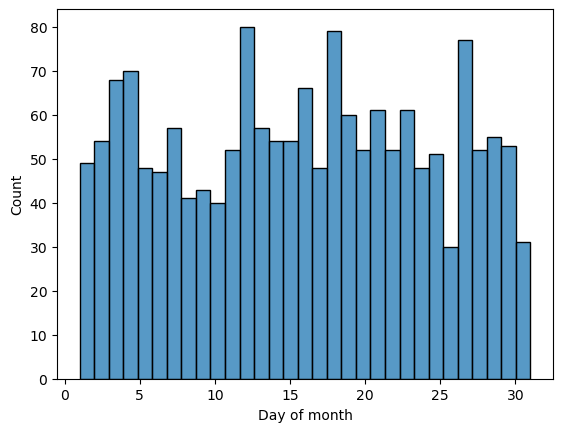

In [12]:
# remove na's
day_of_month_landslides = day_of_month_landslides.dropna()

# plot the day of the month
g=sns.histplot(day_of_month_landslides, kde=False, bins=31)
g.set_xlabel('Day of month')
plt.show()

Yep, it looks like we did parse our dates correctly & this graph makes good sense to me. Why don't you take a turn checking the dates you parsed earlier?

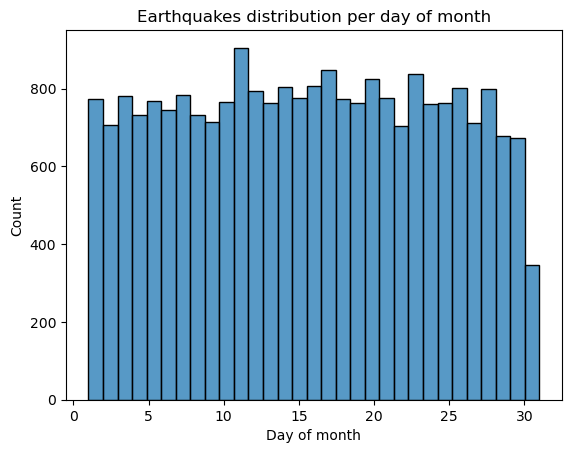

In [13]:
# Your turn! Plot the days of the month from your
# earthquake dataset and make sure they make sense.

# We could remove na's but we already checked there are no null values
# day_of_month_landslides = day_of_month_landslides.dropna()

# plot the day of the month
g=sns.histplot(day_of_month_earthquakes, kde=False, bins=31)
g.set_xlabel('Day of month')
g.set_title('Earthquakes distribution per day of month')
plt.show()

And that's it for today! If you have any questions, be sure to post them in the comments below or [on the forums](https://www.kaggle.com/questions-and-answers). 

Remember that your notebook is private by default, and in order to share it with other people or ask for help with it, you'll need to make it public. First, you'll need to save a version of your notebook that shows your current work by hitting the "Commit & Run" button. (Your work is saved automatically, but versioning your work lets you go back and look at what it was like at the point you saved it. It also lets you share a nice compiled notebook instead of just the raw code.) Then, once your notebook is finished running, you can go to the Settings tab in the panel to the left (you may have to expand it by hitting the [<] button next to the "Commit & Run" button) and setting the "Visibility" dropdown to "Public".

## More practice!

If you're interested in graphing time series, [check out this Learn tutorial](https://www.kaggle.com/residentmario/time-series-plotting-optional).

You can also look into passing columns that you know have dates in them  the `parse_dates` argument in `read_csv`. (The documention [is here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).) Do note that this method can be very slow, but depending on your needs it may sometimes be handy to use.

For an extra challenge, you can try try parsing the column `Last Known Eruption` from the `volcanos` dataframe. This column contains a mixture of text ("Unknown") and years both before the common era (BCE, also known as BC) and in the common era (CE, also known as AD).

In [14]:
volcanos['Last Known Eruption'].sample(5)

329      Unknown
895     1600 BCE
1077     Unknown
562      Unknown
889      1987 CE
Name: Last Known Eruption, dtype: object

In [15]:
volcanos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number               1508 non-null   int64  
 1   Name                 1508 non-null   object 
 2   Country              1508 non-null   object 
 3   Region               1508 non-null   object 
 4   Type                 1508 non-null   object 
 5   Activity Evidence    1507 non-null   object 
 6   Last Known Eruption  1508 non-null   object 
 7   Latitude             1508 non-null   float64
 8   Longitude            1508 non-null   float64
 9   Elevation (Meters)   1508 non-null   int64  
 10  Dominant Rock Type   1455 non-null   object 
 11  Tectonic Setting     1501 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 141.5+ KB


In [16]:
year split(volcanos['Last Known Eruption'])

1103    1170 BCE
1047     2015 CE
159      Unknown
168      Unknown
364      2000 CE
1218     1786 CE
1114     1986 CE
452      Unknown
379      Unknown
201      Unknown
324      1350 CE
240      Unknown
444      2015 CE
1398     1977 CE
164      Unknown
Name: Last Known Eruption, dtype: object

In [59]:
def convert_to_years(year_str):
    if year_str == 'Unknown':
        return 'Unknown'  # or return None if you prefer
    year, era = year_str.split(' ')
    year = int(year)
    if era not in ['CE','BCE']:
        print(era)
    if era == 'BCE':
        return -year  # BCE y'Unknown'ears are negative
    elif era == 'CE':
        return year  # CE years are positive
    else:
        return np.nan  # In case of an invalid format

In [60]:
volcanos['Eruption_year'] = volcanos['Last Known Eruption'].apply(convert_to_years)

In [61]:
volcanos_NaT = volcanos[volcanos['Last Known Eruption']=='Unknown']
volcanos_NaT[(volcanos_NaT['Last Known Eruption']=='Unknown')&(volcanos_NaT['Eruption_year']=='Unknown')][['Last Known Eruption', 'Eruption_year']].size
len(volcanos_NaT)


637

In [63]:
volcanos[['Name','Eruption_year','Last Known Eruption']].sample(10)

,Name,Eruption_year,Last Known Eruption
484,Banua Wuhu,1919,1919 CE
993,Baker,1880,1880 CE
1107,Naolinco Volcanic Field,-1200,1200 BCE
707,Raususan [Mendeleev],1880,1880 CE
456,Ilimuda,Unknown,Unknown
1324,"Atuel, Caldera del",Unknown,Unknown
755,Yavinsky,-4050,4050 BCE
1440,Esjufjoll,Unknown,Unknown
808,Sheveluch,2016,2016 CE
191,"Sawad, Harra Es-",1253,1253 CE
